# Inspect ChromBPNet Model

Inpsect ChromBPNet model and look at footprints, individual loci etc.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data
from metrics import softmax 
import scipy.stats

## Load Data

In [59]:
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    model_bias = tf.keras.models.load_model("../pretrained/c1.chrombpnet.adjusted_bias_model.h5")    
    model = tf.keras.models.load_model("../pretrained/c1.chrombpnet.h5")    

/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1061: UserWarning: archs is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [7]:
INP_LEN = model_bias.input_shape[1]
OUT_LEN = model_bias.output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

In [8]:
TEST_CHR = ["chr1"]
VAL_CHR = ["chr8", "chr10"]

In [9]:
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data("/users/surag/oak/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/overlap_merged/cluster_idx1.bed", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/gc_neg/cluster_idx1.gc.neg.bed", 
                   "/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta", 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx1.bw",
                   TEST_CHR, INP_LEN, OUT_LEN)

## Motif Footprints

In [10]:
def profiles_for_motif(model, model_bias, seqs, motif):
    w_mot_seqs = seqs.copy()
    mid = w_mot_seqs.shape[1]//2 - len(motif)//2
    w_mot_seqs[:, mid:mid+len(motif)] = one_hot.dna_to_one_hot([motif])
    
    raw_seqs_pred_bias, raw_seqs_pred_cts = model_bias.predict(seqs, verbose=True)
    w_mot_seqs_pred_bias, w_mot_seqs_pred_cts = model_bias.predict(w_mot_seqs, verbose=True)
    
    wo_mot_pred_w_bias, wo_mot_pred_w_bias_cts = model.predict([seqs, 
                                                                raw_seqs_pred_bias,
                                                                raw_seqs_pred_cts], 
                                                               verbose=True)

    w_mot_pred_unplug_bias, _ = model.predict([w_mot_seqs, 
                                               np.zeros((w_mot_seqs_pred_bias.shape[0],OUT_LEN)), 
                                                     np.zeros((w_mot_seqs_pred_bias.shape[0],1))],
                                              verbose=True)
    w_mot_pred_w_bias, w_mot_pred_w_bias_cts = model.predict([w_mot_seqs, 
                                          w_mot_seqs_pred_bias,
                                          w_mot_seqs_pred_cts], 
                                          verbose=True)
    
    return(softmax(raw_seqs_pred_bias), softmax(w_mot_seqs_pred_bias), 
           softmax(wo_mot_pred_w_bias), softmax(w_mot_pred_w_bias), 
           softmax(w_mot_pred_unplug_bias),
           wo_mot_pred_w_bias_cts, w_mot_pred_w_bias_cts)

In [11]:
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, start=450, end=550):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_w_bias[:, start:end].mean(0), label='uncorrected')
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0), label='corrected')
    plt.plot(range(width), pred_wo_motif_w_bias[:, start:end].mean(0), '--', label='uncorrected w/o motif')
    plt.legend()
    plt.show()

    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

### tn5 bias motif

In [12]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, test_nonpeaks_seqs[:1000], "CAGTCCTGGACTG")

32/32 [==============================] - 3s 91ms/step


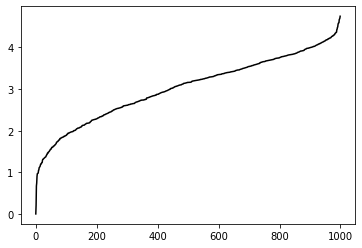

In [13]:
plt.rcParams["figure.figsize"] = (6,4)

# this is the range of tn5 bias
for i in range(1):
    plt.plot(np.sort(np.log10(raw_bias[i])) - np.min(np.log10(raw_bias[i])), alpha=1, c='k')

In [14]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.019534111

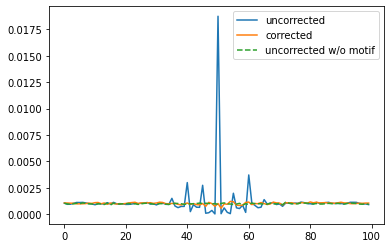

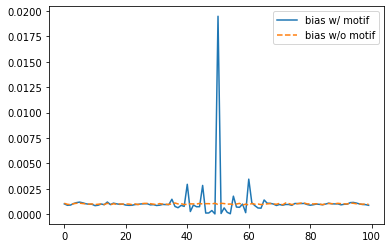

In [15]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias)

The corrected signal is a flat line, which is promising.

### AP1 motif

In [16]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, test_nonpeaks_seqs[1000:2000], "ATGAGTCAT")

32/32 [==============================] - 3s 91ms/step


In [17]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.81321335

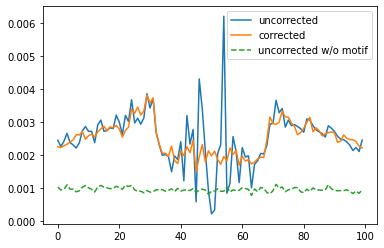

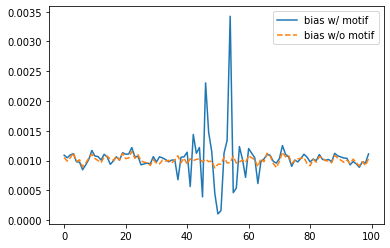

In [18]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias)

The corrected footprint looks much cleaner than uncorrected.

### CTCF Motif

In [19]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, test_nonpeaks_seqs[:1000], "CCCCGGCGCCCCCTGGTGGC")

32/32 [==============================] - 3s 91ms/step


In [20]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

1.4224176

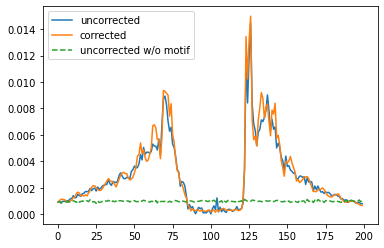

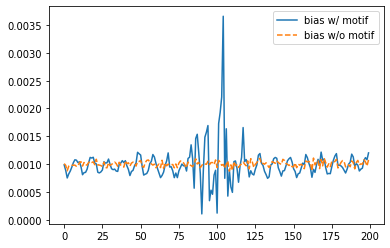

In [21]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, 400, 600)

### Other Motif

In [60]:
raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts \
    = profiles_for_motif(model, model_bias, test_nonpeaks_seqs[:1000], "TTGGCCCTGAGCCAA")

32/32 [==============================] - 3s 91ms/step


In [61]:
np.median(w_mot_w_bias_cts - wo_mot_w_bias_cts)

0.1357212

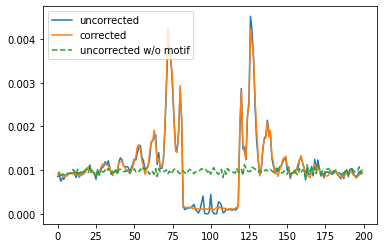

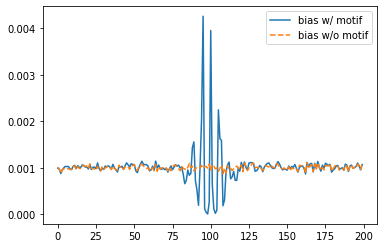

In [62]:
plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, 400, 600)

## Predict and metrics

In [25]:
test_peaks_pred_bias, test_peaks_pred_bias_cts = model_bias.predict(test_peaks_seqs, verbose=True)

514/514 [==============================] - 7s 14ms/step


In [26]:
test_peaks_pred_w_bias, test_peaks_pred_w_bias_cts = model.predict([test_peaks_seqs,
                                                test_peaks_pred_bias,                                                           
                                                test_peaks_pred_bias_cts],
                                                verbose=True)
test_peaks_pred_unplug_bias, test_peaks_pred_unplug_bias_cts = model.predict([test_peaks_seqs,
                                                     np.zeros((test_peaks_seqs.shape[0],OUT_LEN)),
                                                     np.zeros((test_peaks_seqs.shape[0], 1))], verbose=True)

514/514 [==============================] - 47s 91ms/step


Predictions on non-peaks.

In [27]:
test_nonpeaks_pred_bias, test_nonpeaks_pred_bias_cts = model_bias.predict(test_nonpeaks_seqs, verbose=True)

514/514 [==============================] - 7s 14ms/step


In [28]:
test_nonpeaks_pred_w_bias, test_nonpeaks_pred_w_bias_cts = model.predict([test_nonpeaks_seqs,
                                                test_nonpeaks_pred_bias,                                                           
                                                test_nonpeaks_pred_bias_cts],
                                                verbose=True)
test_nonpeaks_pred_unplug_bias, test_nonpeaks_pred_unplug_bias_cts = model.predict([test_nonpeaks_seqs,
                                                np.zeros((test_nonpeaks_seqs.shape[0], OUT_LEN)),                                                           
                                                np.zeros((test_nonpeaks_seqs.shape[0], 1))],
                                                verbose=True)

514/514 [==============================] - 47s 91ms/step


In [29]:
# peaks + nonpeaks performance
scipy.stats.spearmanr(list(test_peaks_pred_w_bias_cts.ravel()) + list(test_nonpeaks_pred_w_bias_cts.ravel()), np.vstack([test_peaks_cts, test_nonpeaks_cts]).sum(-1))

SpearmanrResult(correlation=0.8096928515959751, pvalue=0.0)

In [30]:
# within peaks performance
scipy.stats.spearmanr(test_peaks_pred_w_bias_cts.ravel(), test_peaks_cts.sum(-1))

SpearmanrResult(correlation=0.6466083452684969, pvalue=0.0)

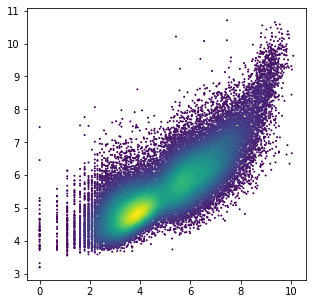

In [225]:
plt.rcParams["figure.figsize"] = (5,5)

x=np.log(1+np.vstack([test_peaks_cts, test_nonpeaks_cts]).sum(-1))
y=list(test_peaks_pred_w_bias_cts.ravel()) + list(test_nonpeaks_pred_w_bias_cts.ravel())

from scipy.stats import gaussian_kde

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=1)
plt.show()

In [32]:
def get_jsd(preds, cts, min_sum=10):
    return np.array([scipy.spatial.distance.jensenshannon(x,y) for x,y in zip(preds, cts) \
                     if y.sum()>min_sum])

In [33]:
# predicted w/ bias
np.median(get_jsd(softmax(test_peaks_pred_w_bias.squeeze()), test_peaks_cts))

0.3803903644506283

In [34]:
# just bias
np.median(get_jsd(softmax(test_peaks_pred_bias.squeeze()), test_peaks_cts))

0.4875024019572345

In [35]:
# predicted w/o bias 
np.median(get_jsd(softmax(test_peaks_pred_unplug_bias.squeeze()), test_peaks_cts))

0.5947514619634842

In [36]:
# permuted
np.median(get_jsd(softmax(test_peaks_pred_w_bias.squeeze())[:,np.random.permutation(OUT_LEN)], test_peaks_cts))

0.7202714723274176

Empricially we've observed that, in general, for ATAC-seq the just bias JSD is lower (i.e. better) tha predicted w/o bias.

## Visualizing Individual Loci

**On peaks**

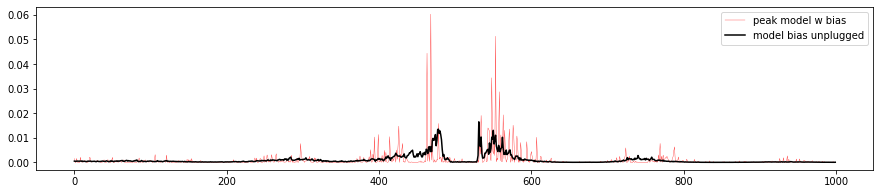

In [51]:
plt.rcParams["figure.figsize"] = (15,3)
IDX = 2822

# plt.plot(softmax(test_peaks_pred_bias)[IDX,], c='g', label='bias only', linewidth=0.6)
plt.plot(softmax(test_peaks_pred_w_bias)[IDX,], c='r', alpha=1, linewidth=.3, label="peak model w bias")
plt.plot(softmax(test_peaks_pred_unplug_bias)[IDX,], c='k', label="model bias unplugged")

# obs_pred = scipy.ndimage.gaussian_filter1d(softmax(test_peaks_pred_w_bias)[IDX,], 2)
# plt.plot(obs_pred/obs_pred.sum(), c='r', alpha=1, linewidth=.3, label="Obs pred")

# obs_smooth = scipy.ndimage.gaussian_filter1d(test_peaks_cts[IDX,], 2)
# plt.plot(obs_smooth/obs_smooth.sum(), c='b', alpha=1, linewidth=.3, label="Obs smoothed")
# plt.plot((test_peaks_cts[IDX, ]/test_peaks_cts[IDX].max())*np.max(softmax(test_peaks_pred_w_bias)[IDX]), c='b', alpha=0.4, label="Read pileup")

plt.legend()

In general, the unplugged track (without bias) should be much smoother than predicted track with bias.

**On non-peaks**

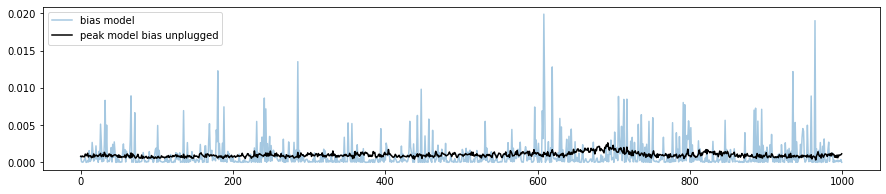

In [58]:
plt.rcParams["figure.figsize"] = (15,3)
IDX = 2004

plt.plot(softmax(test_nonpeaks_pred_w_bias)[IDX, ], alpha=0.4, label="bias model")
plt.plot(softmax(test_nonpeaks_pred_unplug_bias)[IDX, ], c='k',label="peak model bias unplugged")

plt.legend()

It should mostly be a flat-ish line since bias should account for most of the counts.